(Threshold_Free_Metrics)=
# Threshold-free metrics

All the metrics presented in the previous section can only be computed once a confusion matrix is available, which requires setting a decision threshold $t$ on the probabilities that are returned by the classifier. In order to evaluate the performance of a classifier over a range of different thresholds, two well-known assessment techniques are the Receiving Operating Characteristic (ROC) curve and the Precision-Recall (PR) curve. Both techniques allow providing an overall performance score, in the form of the area under the curve (AUC) measure.

This section presents these two techniques and discusses their pros and cons. In particular, we will show that the PR curve and the Average Precision (as the metric that computes the area under the PR curve) are better suited for fraud detection problems than the ROC curve and the AUC ROC, respectively.


In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed
        


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37136  100 37136    0     0   148k      0 --:--:-- --:--:-- --:--:--  148k


(Receiving_Operating_Characteristic_Curve)=
## Receiving Operating Characteristic (ROC) curve

The Receiving Operating Characteristic (ROC) curve {cite}`fawcett2004roc,fawcett2006introduction` is obtained by plotting the Recall (or True Positive Rate - TPR) against the False Positive Rate (FPR) for all the different classification thresholds $t$. It is the *de-facto* standard for estimating the performance of fraud detection systems in the literature {cite}`dal2015adaptive`. 


A classifier K is said to be more performant than a classifier W in the ROC space only if the curve of K always dominates the curve of W. 


<center>
    
![](images/ROC.jpg)
</center>

<div align="center">Fig. 3. The Receiving Operating Characteristic (ROC) curve for two classifiers K and W. <br>The gray line represents the performance of a random model.</div>

The best classifier corresponds to the point (0,1) in the ROC space (no false negatives and no false positives), while a classifier predicting at random would have performances along the diagonal connecting the bottom left corner to the
top right. When there is not a clear winner (e.g. classifier K dominates W only in one part of the ROC space), the comparison is usually done by calculating the Area Under the ROC Curve (AUC ROC). The AUC ROC is usually computed with the *trapezoidal rule* (linearly interpolation) {cite}`fawcett2006introduction`, which provides an expected probability for the TPR and FPR in case of ties in the prediction values.

The ROC curve is obtained by computing the TPR and FPR for all possible fraud probability values returned by a classifier.

Let us illustrate its construction by reusing the simple example presented in the [previous section](Threshold_Based_Metrics). The example contains 10 transactions, among which 2 are fraudulent, and 8 genuine. The labels are given by a list `true_labels`. We assume that a vector of fraud probabilities has been returned by a fraud detector.  The vector of fraud probabilities is given by a list `fraud_probabilities`.

In [3]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]

The first steps in computing the ROC curve consists in getting the list of all unique possible thresholds for which the TPR and FPR will be computed, and sort them by decreasing order. A threshold higher than 1 (set to 1.1) is also added for having the case where all transactions are predicted as genuine. 

In [4]:
unique_thresholds = [1.1]+list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)
unique_thresholds

[1.1, 0.9, 0.45, 0.4, 0.35, 0.2, 0.1, 0]

This gives a list of eight unique thresholds to consider in this example. To these thresholds are associated all the possible (TPR, FPR) that the classifier can return.

Reusing the `threshold_based_metrics` function defined in the previous section, let us compute the TPR and FPR for each of these thresholds. 

In [6]:
performance_metrics=threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)
performance_metrics[['Threshold','TPR','FPR']]

,Threshold,TPR,FPR
0,1.10,0.0,0.000
1,0.90,0.5,0.000
2,0.45,0.5,0.125
3,0.40,0.5,0.250
4,0.35,1.0,0.250
5,0.20,1.0,0.625
6,0.10,1.0,0.875
7,0.00,1.0,1.000


As expected, the lower the threshold, the higher the TPR (more frauds are detected), but the higher the FPR (more genuine transactions are classified as fraudulent). The first point of the curve consists in predicting all transactions as genuine (threshold 1.1). The resulting TPR is zero (no detected fraud), and FPR is 0 (no false positive). The last point of the curve consists in predicting all transactions as fraudulent (threshold 0). The resulting TPR is one (all frauds detected), and FPR is 1 (all genuine transactions misclassified as frauds). 

Since the ROC curve is a standard metric in classification, the Python library `sklearn.metrics` provides a function `roc_curve` to compute the thresholds, as well as the corresponding FPR and TPR. 

In [8]:
FPR_list, TPR_list, threshold = sklearn.metrics.roc_curve(true_labels, fraud_probabilities, drop_intermediate=False)
FPR_list, TPR_list, threshold

(array([0.   , 0.   , 0.125, 0.25 , 0.25 , 0.625, 0.875, 1.   ]),
 array([0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. ]),
 array([1.9 , 0.9 , 0.45, 0.4 , 0.35, 0.2 , 0.1 , 0.  ]))

Let us now plot the resulting ROC curve. We note that the first threshold (1.9) differs from the one we chose earlier (1.1). This is because the `sklearn.metrics.roc_curve` function sets the first threshold to 1 plus the second threshold (0.9), giving 1.9 in this case. 

In [9]:
%%capture
def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")

ROC_AUC = metrics.auc(FPR_list, TPR_list)    
    
roc_curve, ax = plt.subplots(figsize=(5,5))
get_template_roc_curve(ax, "Receiver Operating Characteristic (ROC) Curve",fs=15)
ax.plot(FPR_list, TPR_list, 'b', color='blue', label = 'AUC ROC Classifier = {0:0.3f}'.format(ROC_AUC))
ax.legend(loc = 'lower right')

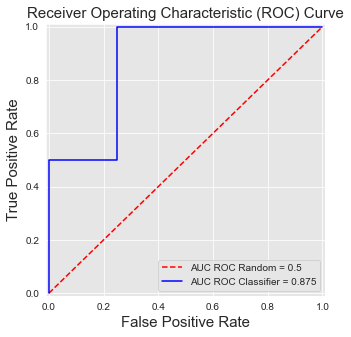

In [10]:
roc_curve

ROC curves have three important properties {cite}`fernandez2018learning`. First, they are monotonic functions: The TPR can only increase as the FPR increases. Second, the area under the curve has a probabilistic interpretation: The AUC ROC can be interpreted as the probability that the scores given by a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. Third, the AUC ROC of a random classifier is $0.5$.   

The last property can be easily checked by setting all predictions to 0.5. This gives a list of only two thresholds. The first is 1.5, which classifies all predictions as genuine. The second is 0.5, which classifies all predictions as fraudulent.  

In [11]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.5]*10

FPR_list, TPR_list, threshold = metrics.roc_curve(true_labels, fraud_probabilities, drop_intermediate=False)
FPR_list, TPR_list, threshold

(array([0., 1.]), array([0., 1.]), array([1.5, 0.5]))

In [12]:
%%capture

ROC_AUC = metrics.auc(FPR_list, TPR_list)    
    
roc_curve, ax = plt.subplots(figsize=(5,5))
get_template_roc_curve(ax, "Receiver Operating Characteristic (ROC) Curve\n Random classifier",fs=15,random=False)
ax.plot(FPR_list, TPR_list, 'b', color='blue', label = 'AUC ROC Classifier = {0:0.3f}'.format(ROC_AUC))
ax.legend(loc = 'lower right')

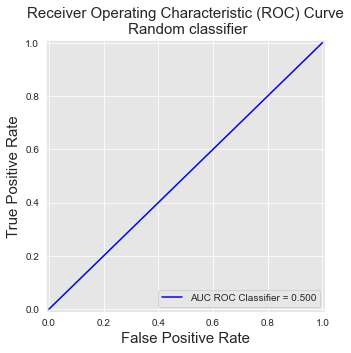

In [13]:
roc_curve

This results in a line going from [0,0] to [1,1]. The resulting AUC ROC is the area under this line, which is 0.5.

Let us now reuse the experimental setting of the [baseline fraud detection system](Baseline_FDS) presented in Chapter 3. One week of data is used for training, and one week for testing. Five prediction models are considered: logistic regression, a decision tree with depth two and a decision tree of unlimited depth, a random forest with 25 trees, and a boosting model with default parameters. The ROC curves and their AUC are reported below for the five models.


In [14]:
# Load data from the 2018-07-25 to the 2018-08-14

DIR_INPUT='./simulated-data-transformed/data' 

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=delta_delay=delta_test=7

(train_df,test_df)=get_train_test_set(transactions_df,start_date_training,
                                      delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    start_time=time.time()
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                          input_features=input_features,
                                                          output_feature=output_feature)
    
    print("Time to fit the "+classifier_name+" model: "+str(round(time.time()-start_time,2)))
    
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions
    

Load  files
CPU times: user 196 ms, sys: 155 ms, total: 351 ms
Wall time: 375 ms
201295 transactions loaded, containing 1792 fraudulent transactions
Time to fit the Logistic regression model: 0.73
Time to fit the Decision tree with depth of two model: 0.45
Time to fit the Decision tree - unlimited depth model: 1.3
Time to fit the Random forest model: 9.15
[10:53:15] WARNING: /private/var/folders/wz/86tkhhmd5gxgh4f24bdl9l2m0000gn/T/pip-install-o8iul8v_/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time to fit the XGBoost model: 7.49


In [15]:
%%capture
roc_curve, ax = plt.subplots(1, 1, figsize=(5,5))

cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200), 
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40)}

get_template_roc_curve(ax,title='Receiver Operating Characteristic Curve\nTest data',fs=15)
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    FPR_list, TPR_list, threshold = metrics.roc_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    ROC_AUC = metrics.auc(FPR_list, TPR_list)

    ax.plot(FPR_list, TPR_list, 'b', color=colors[classifier_name], label = 'AUC ROC {0}= {1:0.3f}'.format(classifier_name,ROC_AUC))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    

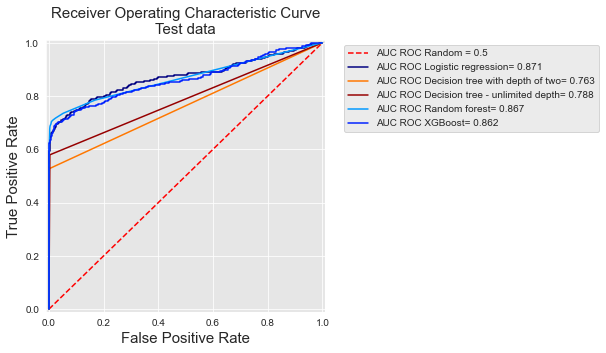

In [16]:
roc_curve

The curves show that decision trees have the lowest performances, while random forest, logistic regression, and boosting have similar performances. We can note that the curves for the two decision trees have only a few points. For the tree with depth two, the reason is that it only has four leaves, so it only predicts four different values, and therefore has only four possible thresholds. For the tree with unlimited depth, the reason that is that all its leaves are pure on the training set (they either predict a probability of 1 or a probability of 0). Therefore this model only has two possible thresholds.

ROC curves are relevant to get a sense of a classifier performance over the whole range of possible FPR. Their interest for fraud detection is however limited since an important goal of fraud detection is to keep the FPR very low. 

To get a sense of how low the FPR should be kept, let us recall that false positives are genuine transactions that are predicted as fraudulent. In an operational fraud system, these transactions will need to be manually handled by investigators. Due to the limited number of investigators, there is only a limited amount of transactions that can be checked. 

Let us consider more concretely how this constraint translates in terms of FPR. 

In this example, the dataset contains 58264 transactions (over 7 days), among which 57879 are genuine, and 385 fraudulent.

In [17]:
test_df[test_df.TX_FRAUD==0].shape

(57879, 23)

In [18]:
test_df[test_df.TX_FRAUD==1].shape

(385, 23)

Assuming that 100 transactions can be checked every day, a total of 700 transactions could be checked after 7 days, that is, around 1% of the transactions. Therefore, any FPR higher than 0.01 will raise more alerts that can be handled by investigators.

Real-world fraud detection systems typically handle hundreds of thousands to millions of on a daily basis. The proportion of transactions that can be manually checked is in fact closer to 0.1% than 1%. That is, any FPR higher than 0.001 is already too high. 

As a result, due to the imbalanced nature of the problem, 99.9% of what is represented on the ROC curve has little relevance from the perspective of an operational fraud detection system where fraudulent transactions must be checked by a limited team of investigators. 

We refer the reader to {cite}`saito2015precision` for an in-depth discussion of the inadequacy of the ROC curve for imbalanced problems, and the motivations for using the Precision-Recall curve instead.  

(Precision_Recall_Curve)=
## Precision-Recall curve

The Precision-Recall curve (PR curve) is obtained by plotting the precision against the recall (or True Positive Rate - TPR) for all the different classification thresholds $t$. The main advantage of the PR curve is to put in evidence classifiers that can have both a high recall and a high precision (which indirectly translates to a high TPR and a low FPR).

Let us reuse the same example as above, and compute the precision and recall for the eight unique thresholds.


In [19]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]

unique_thresholds = [1.1]+list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)

performance_metrics=threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)
performance_metrics[['Threshold','Precision','TPR']]

,Threshold,Precision,TPR
0,1.10,1.000000,0.0
1,0.90,1.000000,0.5
2,0.45,0.500000,0.5
3,0.40,0.333333,0.5
4,0.35,0.500000,1.0
5,0.20,0.285714,1.0
6,0.10,0.222222,1.0
7,0.00,0.200000,1.0


Let us now plot the PR curve, and compute its AUC. We will use the Average Precision (AP), which summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight {cite}`boyd2013area,fan2011detection`.

$$
AP=\sum_n(R_n-R_{n-1})*P_n
$$

where $P_n$ and $R_n$ are the precision and recall at the $n$-th threshold. 

An implementation of the average precision is provided below.

In [20]:
def compute_AP(precision, recall):
    
    AP = 0
    
    n_thresholds = len(precision)
    
    for i in range(1, n_thresholds):
        
        if recall[i]-recall[i-1]>=0:
            
            AP = AP+(recall[i]-recall[i-1])*precision[i]
        
    return AP

The plotting is obtained by using the `step` function from `matplotlib`.

In [22]:
%%capture
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))

precision = performance_metrics.Precision.values
recall = performance_metrics.TPR.values
    
pr_curve, ax = plt.subplots(figsize=(5,5))
get_template_pr_curve(ax, "Precision Recall (PR) Curve",fs=15,baseline=sum(true_labels)/len(true_labels))
AP2 = metrics.average_precision_score(true_labels, fraud_probabilities)
AP = compute_AP(precision, recall)
ax.step(recall, precision, 'b', color='blue', label = 'AP Classifier = {0:0.3f}'.format(AP))
ax.legend(loc = 'lower right')


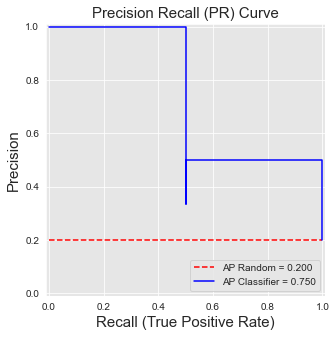

In [23]:
pr_curve

PR curves behave differently from ROC curves. We detail these differences in the following. 

First, they are not monotonic: The precision may decrease or increase, as the recall increases. This is illustrated above, where for a recall of $0.5$, the precision first goes down to $0.33$ (threshold $0.4$), before going up to $0.5$ (threshold $0.35$). 

Second, their AUC does not carry a statistical interpretation as ROC AUC. However, it can be shown that there exists a one-to-one correspondence between PR and ROC curves, and that a curve that dominates in the PR space necessarily dominates in the ROC space {cite}`davis2006relationship`. 

Third, the performance of a random classifier depends on the class imbalance. It is $0.5$ in the balanced case, and $P/(P+N)$ in the general case, where $P$ is the number of positive examples, and $N$ the number of negative examples. In particular, a classifier that classifies all examples as positive (recall of 1) has a precision of $P/(P+N)$. In the example above, this gives a precision of $2/(2+8)=0.2$, highlighted with the dotted red line. This property makes the AP more interesting than the AUC ROC in a fraud detection problem, since it better reflects the challenge related to the class imbalance problem (the AP of a random classifier decreases as the class imbalance ratio increases).  

```{warning}
Linear interpolation (as is used for ROC curves) should not be used for plotting PR curves, nor for assessing their AUC. The use of the step-wise function for plotting, and AP as a measure of AUC are well established. We refer the reader to {cite}`saito2015precision,flach2015precision,davis2006relationship` for detailed discussions on the topic, and the use of alternative ways to plot the PR curve or assess its AUC.  
```

Let us finally reuse the experimental setting of the previous section, and plot the PR curves and corresponding AP for each of the five prediction models.

In [24]:
%%capture
pr_curve, ax = plt.subplots(1, 1, figsize=(6,6))
cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200), 
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40)}

get_template_pr_curve(ax, "Precision Recall (PR) Curve\nTest data",fs=15,baseline=sum(test_df[output_feature])/len(test_df[output_feature]))
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    precision, recall, threshold = metrics.precision_recall_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    precision=precision[::-1]
    recall=recall[::-1]
    
    AP = metrics.average_precision_score(test_df[output_feature], model_and_predictions['predictions_test'])
    
    ax.step(recall, precision, 'b', color=colors[classifier_name], label = 'AP {0}= {1:0.3f}'.format(classifier_name,AP))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    
    
plt.subplots_adjust(wspace=0.5, hspace=0.8)

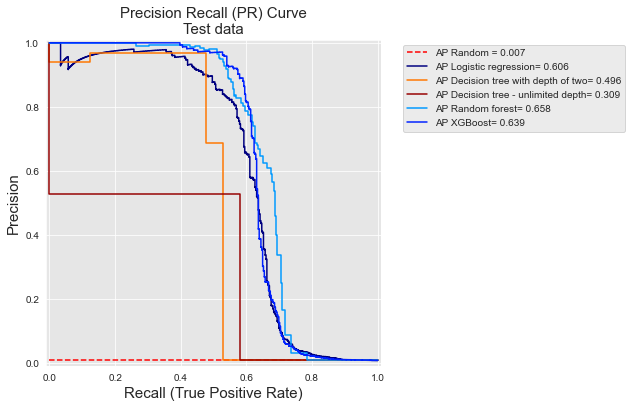

In [25]:
pr_curve

And let us compare these PR curves with the ROC curves.

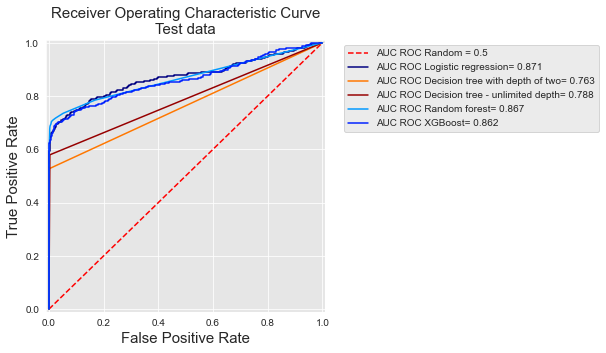

In [26]:
roc_curve

At first sight, PR and ROC curves give a very different picture of the relative performances of the different classifiers. In order to better relate the two types of curve, it is useful to mentally 'transpose' the PR curve in such a way that the x-axis represents the precision, and the y-axis represents the True Positive Rate. Once transposed, both curves represent the TPR on their y-axis, and one can note that the PR curve is actually a zoomed version of the ROC curves for very low values of the False Positive Rate.

As pointed out above at the end of the section on ROC curves, the TPR for low FPR values is actually what matters in a fraud detection problem: The number of cards that can be manually checked by fraud investigators is in practice very limited. This also gives a different ordering of performances for the classifiers. For example, with ROC curves, decision trees with unlimited depth have a better AUC than a decision tree of depth two (0.788 versus 0.763, respectively). The performances are reversed when computed in terms of Average Precision (0.309 versus 0.496). 

While PR curves are useful to highlight the performances of fraud detection systems for low FPR values, they however remain difficult to interpret from an operational point of view. The next section addresses this issue, by discussing [Precision top-$k$ metrics](Precision_Top_K_Metrics).
 